In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

2021-11-09 12:21:29.969730: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-09 12:21:29.969776: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_excel("data train.xlsx")

In [3]:
df['sentiment'] = df['sentiment'].fillna(value=2)
df['sentiment'] = df['sentiment'].astype(int)
df['text'] = df['text'].replace('\s+', ' ', regex=True)
df['text'] = df['text'].fillna('').apply(str)
df['text'] = df['text'].replace({'"':'',
                                 '\d+':'',
                                 ':':'',
                                 ';':'',
                                 '#':'',
                                 '@':'',
                                 '_':'',
                                 ',': '',
                                 "'": '',
                                  }, regex=True)

df['text'] = df['text'].str.replace(r'[https]+[?://]+[^\s<>"]+|www\.[^\s<>"]+[?()]+[(??)]+[)*]+[(\xa0]+[-&gt...]', "",regex=True)

df['text'] = df['text'].replace('\n','', regex=True)

df['text'] = df['text'].replace({'\.':'','(/)':'','\(':'','\)':''},regex=True)
df['text'] = df['text'].replace('[\.:"]','',regex =True)

df['text'] = df['text'].fillna('').apply(str)

df['text'].astype(str)
letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(df['text']))
df['text'] = df['text'].str.strip()
df['text'] = df['text'].str.lower()

In [4]:
df['sentiment'] = df['sentiment'].replace({1:0,2:1,3:2})
df.head(100)

,text,sentiment,Unnamed: 2
0,menurut johnny g plate upaya itu sama seperti ...,1,NaN
1,raymax justbob adisareang wah punya pt pos ind...,1,NaN
2,bgkyrborn mastbp liaisti ellykoro mamakeabien ...,1,NaN
3,telegram bukannya jaman jadul banget tuh produ...,2,NaN
4,agenda transformatif ini tidak hanya ditujukan...,2,NaN
...,...,...,...
95,bravobeacukai dimana saya bisa hubungi pos ind...,1,NaN
96,bravobeacukai punten ingin tanya kakkalau impo...,1,NaN
97,briankhis amaan kok tegantung deh kan ada mace...,1,NaN
98,brklynbrnx paket lbde sudah rilis dan lunas pa...,1,NaN


In [5]:
df_neg = df[df['sentiment'] == 0]
df_net = df[df['sentiment'] == 1]
df_pos = df[df['sentiment'] == 2]
print(f"negatif shape {df_neg.shape}")
print(f"netral shape {df_net.shape}")
print(f"postif shape {df_pos.shape}")
print(f"total shape {df.shape}")

negatif shape (404, 3)
netral shape (484, 3)
postif shape (640, 3)
total shape (1528, 3)


In [6]:
X = df['text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
vocab_size = 20000
embedding_dim = 10
max_length = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [8]:
import numpy as np
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(X)

word_index =tokenizer.word_index

training_sequence = tokenizer.texts_to_sequences(X_train)
testing_sequence = tokenizer.texts_to_sequences(X_test)

training_padding = pad_sequences(training_sequence,maxlen=max_length,padding=padding_type)
test_padding = pad_sequences(training_sequence,maxlen=max_length,padding=padding_type)

training_padded = np.array(training_padding)
training_label = np.array(y_train)

test_padded = np.array(test_padding)
test_label = np.array(y_test)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length ),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(20,activation='sigmoid'),
    tf.keras.layers.Dense(40,activation='sigmoid'),
    tf.keras.layers.Dense(3,activation='sigmoid')

])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

2021-11-09 12:21:33.874966: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-09 12:21:33.875015: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-09 12:21:33.875045: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (levi-Aspire-A315-41): /proc/driver/nvidia/version does not exist
2021-11-09 12:21:33.875411: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
num_epoch = 300
history = model.fit(training_padded,training_label,batch_size = 32,epochs=num_epoch)

Epoch 1/300
39/39 [==============================] - 1s 4ms/step - loss: 1.1430 - accuracy: 0.3707
Epoch 2/300
39/39 [==============================] - 0s 4ms/step - loss: 1.0844 - accuracy: 0.4100
Epoch 3/300
39/39 [==============================] - 0s 4ms/step - loss: 1.0857 - accuracy: 0.4100

In [12]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy'])


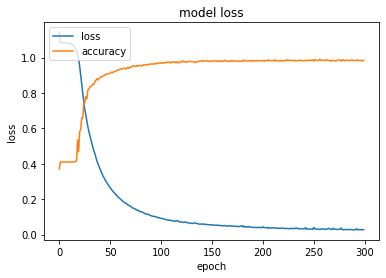

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

In [14]:
sentence = ["kurir pos lama"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)
predic2 = model.predict(padded)

In [40]:
import numpy as np
y_label = {0:"negative",1:"neutral",2:"positive"}
prediction = np.array(predic2)
print(y_label[np.argmax(prediction)])


negative


In [41]:
data_predict = pd.read_excel("data done 1.xlsx")
data_predict = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
data_predict.head()
data_predict = data_predict.dropna()
data_predict.isna().sum()
data_predict

,text,sentiment,Unnamed: 2
0,menurut johnny g plate upaya itu sama seperti ...,1,nan
1,raymax justbob adisareang wah punya pt pos ind...,1,nan
2,bgkyrborn mastbp liaisti ellykoro mamakeabien ...,1,nan
3,telegram bukannya jaman jadul banget tuh produ...,2,nan
4,agenda transformatif ini tidak hanya ditujukan...,2,nan
...,...,...,...
1523,yuk ah udah pada install pospay belum? jangan ...,2,nan
1524,yuk ah udah pada install pospay belum? jangan ...,2,nan
1525,yuk ah udah pada install pospay belum? jangan ...,2,nan
1526,yuk share pernah ada cerita menarik apa tentan...,1,nan


In [42]:
data = data_predict['text'].tolist()
data[:5]

['menurut johnny g plate upaya itu sama seperti perjuangan soetoko bersama para pahlawan angkatan muda pos telegraf dan telepon amptt di mana amptt membebaskan jawatan ptt yang sekaligus merintis awal mula sektor pos dan telekomunikasi indonesia',
 'raymax justbob adisareang wah punya pt pos indonesia ya?',
 'bgkyrborn mastbp liaisti ellykoro mamakeabien hemaviton moga pelayanannya jg lbh hebat lg yajgn sampe pos indonesia masuk bottom worst lg*pengalaman tukang sortir ga suka robek perangko lg kan?? *pengalamanlagi',
 'telegram bukannya jaman jadul banget tuh produk pos indonesia yang kalau dapat telegram pasti langsung shock banyakan berita duka cita',
 'agenda transformatif ini tidak hanya ditujukan agar sektor pos dan telekomunikasi indonesia dapat semakin maju tetapi juga untuk mendorong perluasan akses dan kebermanfaatan teknologi digital']

In [43]:
sequences_pred = tokenizer.texts_to_sequences(data)
padded_pred = pad_sequences(sequences_pred,maxlen=max_length,padding=padding_type,truncating=trunc_type)
input_prediction = model.predict(padded_pred)
input_prediction[:3]

array([[7.4880123e-03, 9.9968225e-01, 4.3714046e-04],
       [1.3278812e-02, 9.8096234e-01, 2.1901906e-02],
       [5.7504475e-03, 9.9678981e-01, 6.6783726e-03]], dtype=float32)

In [46]:
y_label = {0:"negative",1:"neutral",2:"positive"}
pred_res = np.array(input_prediction)
print(pred_res[:4])

[[7.4880123e-03 9.9968225e-01 4.3714046e-04]
 [1.3278812e-02 9.8096234e-01 2.1901906e-02]
 [5.7504475e-03 9.9678981e-01 6.6783726e-03]
 [1.8396974e-04 8.8538694e-01 8.5959011e-01]]


KeyError: 330

In [50]:
sentimen = []
for x in pred_res:
    sentimen.append(y_label[np.argmax(x)])


In [52]:
data_clean = pd.DataFrame({'tweet':data_predict['text'],'sentimen':sentimen})
data_clean

,tweet,sentimen
0,menurut johnny g plate upaya itu sama seperti ...,neutral
1,raymax justbob adisareang wah punya pt pos ind...,neutral
2,bgkyrborn mastbp liaisti ellykoro mamakeabien ...,neutral
3,telegram bukannya jaman jadul banget tuh produ...,neutral
4,agenda transformatif ini tidak hanya ditujukan...,neutral
...,...,...
1523,yuk ah udah pada install pospay belum? jangan ...,positive
1524,yuk ah udah pada install pospay belum? jangan ...,positive
1525,yuk ah udah pada install pospay belum? jangan ...,positive
1526,yuk share pernah ada cerita menarik apa tentan...,neutral


In [53]:
data_clean.to_excel("tensorflow testing sentimen.xlsx")
